In [37]:
import sys
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns 
import scanpy as sc
import umap.umap_ as umap  

from importlib import reload

import plotting as plt2

In [2]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/clustered.anndata.h5ad"

adata = sc.read_h5ad(fpath)
adata.uns['X_umap'] = adata.obsm['X_umap']
adata

AnnData object with n_obs × n_vars = 8574 × 15065
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ensembl_id'
    uns: 'HSC_vs_FB', 'HSC_vs_FB_pure', 'clusters', 'fb_vs_hsc_up', 'go_annotations', 'hsc_v_fib_up', 'hvg', 'log1p', 'neighbors', 'panglaodb', 'pca', 'scenic_transcription_factors', 'scrublet', 'tabula_sapiens_deg', 'umap', 'v5_tags', 'X_umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'filtered_counts', 'raw_counts'
    obsp: 'connectivities', 'distances'

In [3]:
# load BJ data
bj = pd.read_csv("/nfs/turbo/umms-indikar/shared/projects/R01/BJ_FIB_GENES.csv")
bj = bj.sort_values(by='tpm', ascending=False)

bj_nz = bj[bj['log_tpm'] > 0 ] # a non-zero version

bj.head()



,gene_name,tpm,log_tpm,rank,is_panglao_marker
0,TMSB10,45584.16,10.727338,1.0,False
1,S100A6,35129.31,10.466820,2.0,False
2,LGALS1,22412.13,10.017402,3.0,False
3,TMSB4X,15365.34,9.639935,4.0,False
4,MYL6,14625.02,9.590557,5.0,False


In [4]:
n_genes = 20

pan = adata.uns['panglaodb']
fib = pan[pan['cell_type'] == 'Fibroblasts']
fib = pd.merge(bj, fib, how='left', 
               left_on='gene_name',
               right_on='gene_name',
              )

fib = fib[fib['cell_type'].notna()]
fib = fib.sort_values(by='log_tpm', ascending=False)
fib = fib.head(n_genes)

fib.head()

,gene_name,tpm,log_tpm,rank,is_panglao_marker,cell_type,ubiquitousness_index,gene_type,organ,sensitivity_human,specificity_human,ensembl_id
6,S100A4,8394.92,9.035501,7.0,True,Fibroblasts,0.098,protein-coding gene,Connective tissue,0.747748,0.357676,ENSG00000196154
92,FSTL1,888.86,6.791064,93.0,True,Fibroblasts,0.123,protein-coding gene,Connective tissue,0.594595,0.091853,ENSG00000163430
139,SPARC,621.73,6.434113,140.0,True,Fibroblasts,0.307,protein-coding gene,Connective tissue,0.837838,0.209023,ENSG00000113140
230,COL1A2,361.32,5.892528,231.0,True,Fibroblasts,0.097,protein-coding gene,Connective tissue,0.711712,0.103213,ENSG00000164692
268,LUM,297.36,5.698301,269.0,True,Fibroblasts,0.051,protein-coding gene,Connective tissue,0.873874,0.058747,ENSG00000139329


In [5]:
sample_size = 100
adata.var_names = adata.var['gene_name'].values
df = adata[:, fib['gene_name'].values].to_df().reset_index()
df = df.sample(sample_size)

df = pd.melt(df, id_vars='cell_id')
df.head()

,cell_id,variable,value
0,TGGCGTGGTCGCAACC,S100A4,0.000000
1,AGCGTCGCAAGGTACG,S100A4,1.321426
2,TGGATCACAAGATCCT,S100A4,0.000000
3,CACTTCGCAGCAGAAC,S100A4,0.000000
4,TGCAGATTCAAGTGGG,S100A4,0.000000


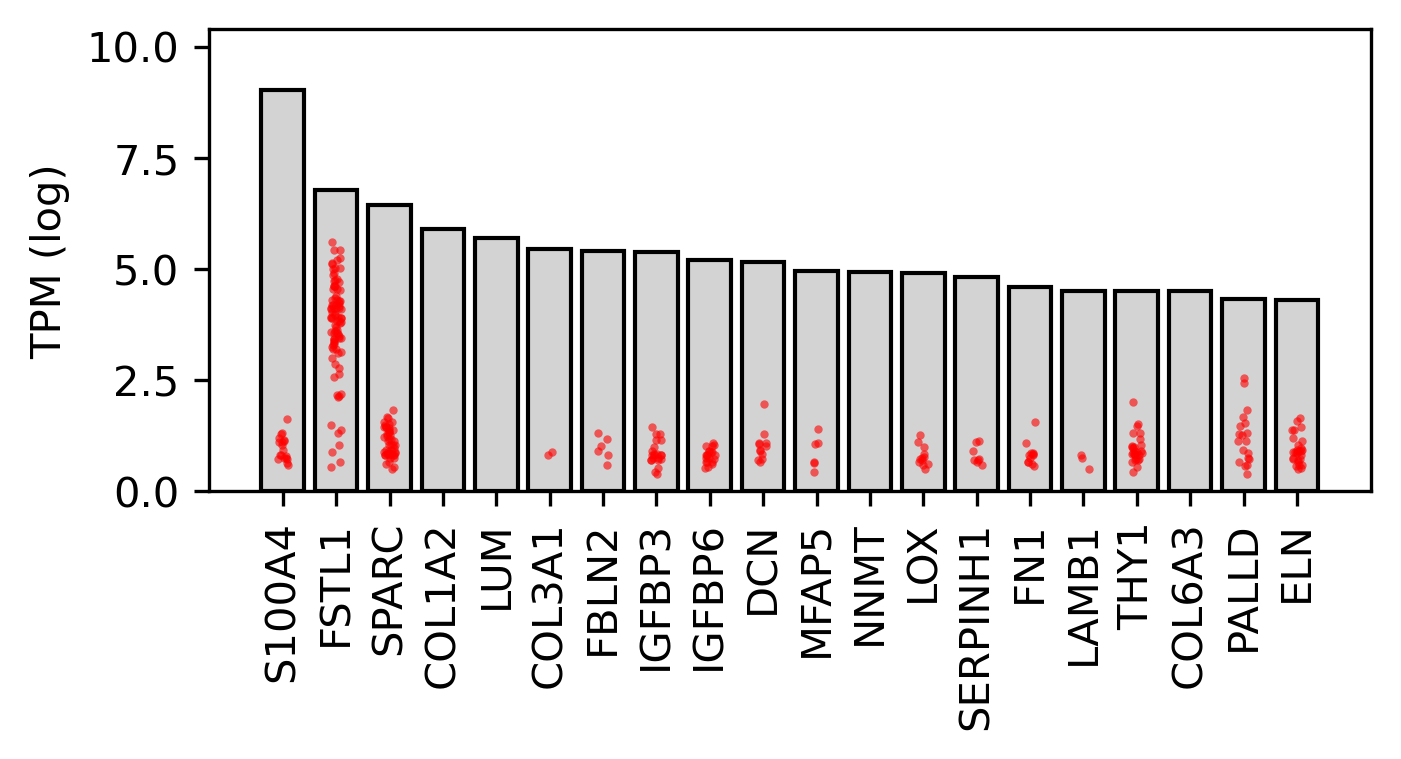

In [6]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 2

sns.barplot(data=fib,
            x='gene_name',
            y='log_tpm',
            ec='k',
            color='lightgrey',
           )

sns.stripplot(data=df[df['value'] > 0], 
            x='variable',
            y='value',
            c='r',
            size=2,
            alpha=0.6,
             )

plt.ylabel("TPM (log)")
plt.xlabel("")

plt.gca().tick_params(axis='x', rotation=90)
plt.margins(x=0.05, y=0.15)

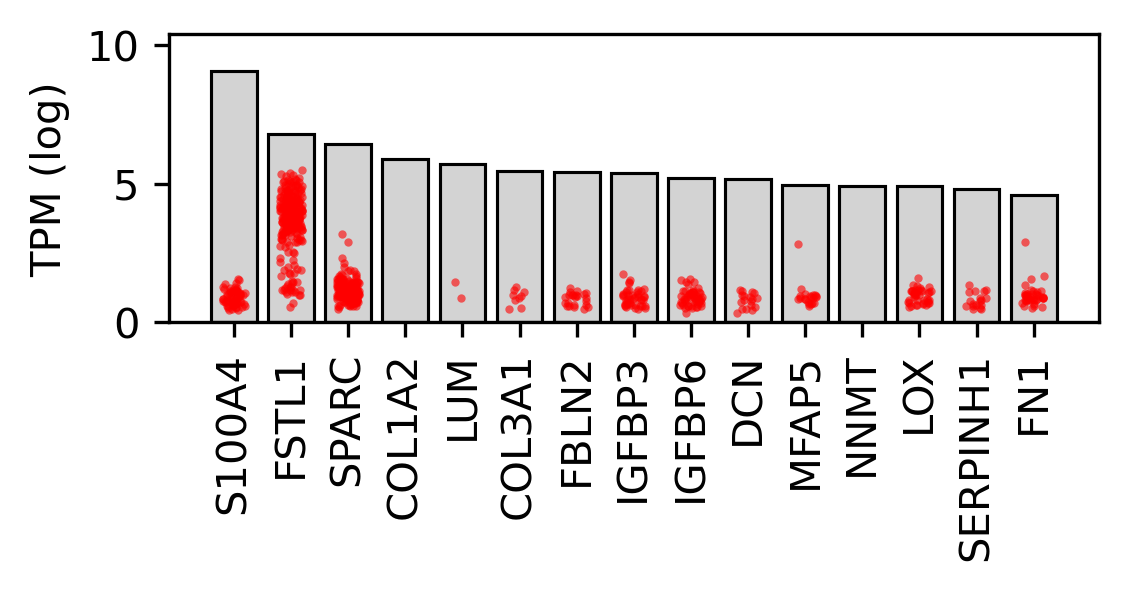

In [7]:
def plot_gene_expression_by_cell_type(
    adata,
    bj,
    n_genes: int = 20,
    sample_size: int = 100,
    database_key: str = 'panglaodb',
    filter_column: str = 'cell_type',
    filter_value: str = 'Fibroblasts',
    sort_column: str = 'log_tpm',
    ascending: bool = False
) -> None:
    """
    Plots top expressed genes for a specific cell type and their expression in a sample of cells.

    Args:
        adata: An AnnData object containing gene expression data.
        bj: A DataFrame containing gene information (must have 'gene_name' column).
        n_genes: Number of top genes to plot. Defaults to 20.
        sample_size: Number of cells to sample for the stripplot. Defaults to 100.
        database_key: Key in adata.uns for the DataFrame containing cell type information.
        filter_column: Column in the database to filter by.
        filter_value: Value in the filter_column to select cells.
        sort_column: Column to sort the cell_data by (e.g., 'log_tpm', 'mean_expression').
        ascending: Whether to sort in ascending order. Defaults to False (descending).
    """
    database = adata.uns.get(database_key, pd.DataFrame())
    filtered_cells = database[database[filter_column] == filter_value]
    cell_data = pd.merge(
        bj, filtered_cells, how='left', left_on='gene_name', right_on='gene_name'
    )

    cell_data = cell_data.dropna(subset=[filter_column])
    cell_data = cell_data.sort_values(by=sort_column, ascending=ascending).head(n_genes)

    adata.var_names = adata.var.get('gene_name', pd.Series()).values
    df = adata[:, cell_data['gene_name'].values].to_df().reset_index()
    df = df.sample(sample_size)
    df = pd.melt(df, id_vars='cell_id')

    sns.barplot(
        data=cell_data,
        x='gene_name',
        y=sort_column,  # Use the specified sort column for the y-axis
        color='lightgrey',
        edgecolor='black',
        linewidth=0.75,
    )

    sns.stripplot(
        data=df[df['value'] > 0],
        x='variable',
        y='value',
        color='red',
        size=2,
        alpha=0.6,
        jitter=0.2
    )

    plt.ylabel("TPM (log)")
    plt.xlabel("")
    plt.gca().tick_params(axis='x', rotation=90)
    plt.margins(x=0.05, y=0.15)
    plt.show()
    
    
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 1.25
plot_gene_expression_by_cell_type(adata, bj, n_genes=15, sample_size=300)    

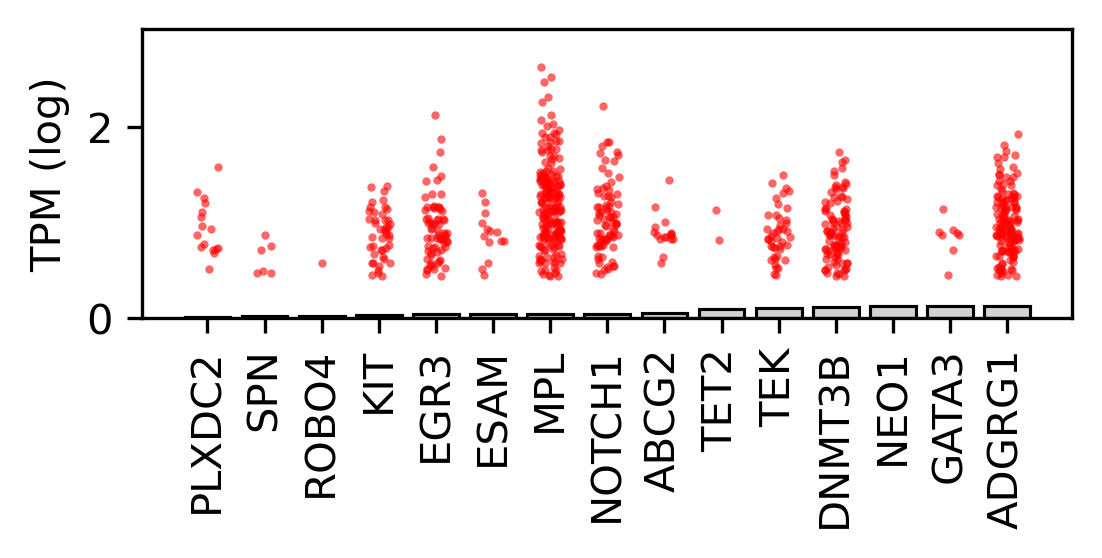

In [8]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 1.25
plot_gene_expression_by_cell_type(adata, bj_nz, n_genes=15, sample_size=300, 
                                  filter_value='Hematopoietic stem cells',
                                  ascending=True)    

# phenotypic clustering

In [11]:
adata.var_names = adata.var['gene_name'].values
adata.var_names[:10]

Index(['ATAD3B', 'SKI', 'PEX14', 'PLCH2', 'SPSB1', 'HES3', 'PLEKHM2', 'CA6',
       'NMNAT1', 'CCDC27'],
      dtype='object')

In [12]:
adata

AnnData object with n_obs × n_vars = 8574 × 15065
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ensembl_id'
    uns: 'HSC_vs_FB', 'HSC_vs_FB_pure', 'clusters', 'fb_vs_hsc_up', 'go_annotations', 'hsc_v_fib_up', 'hvg', 'log1p', 'neighbors', 'panglaodb', 'pca', 'scenic_transcription_factors', 'scrublet', 'tabula_sapiens_deg', 'umap', 'v5_tags', 'X_umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'filtered_counts', 'raw_counts'
    obsp: 'connectivities', 'distances'

In [42]:
gene_list = [
    'CD34',
    'PTPRC',
    'GATA2',
    'FOS',
    'GFI1B',
    'STAT5A',
    'REL',
]

pdf = pd.DataFrame({'cell_id' : adata.obs.index})

for gene in gene_list:
    pdf[gene] = adata[:, gene].X > 0
    
pdf = pdf.set_index('cell_id')
pdf.head()

,CD34,PTPRC,GATA2,FOS,GFI1B,STAT5A,REL
cell_id,,,,,,,
AAACCCAAGGTTACCT,True,True,True,False,True,True,False
AAACCCAAGTTGAAGT,False,True,False,False,False,False,False
AAACCCAAGTTGTCGT,False,False,True,False,False,False,False
AAACCCACAGAAGCGT,True,True,False,False,True,False,False
AAACCCACAGGAGGTT,True,True,True,False,False,False,False


In [55]:
def cluster_on(adata, gene_list, resolution=1, key_added='gene_cluster'):
    """A function to cluster only on a subset of genes """
    data = adata.copy()
    data.obsm['gene_subset'] = adata[:, gene_list].X
    sc.pp.neighbors(data, use_rep='gene_subset')
    sc.tl.leiden(data, 
             resolution=resolution, 
             key_added=key_added)
    sc.tl.umap(data)
    return data
    
    
gene_list = [
    'CD34',
    'PTPRC',
    'GATA2',
    'FOS',
    'GFI1B',
    'STAT5A',
    'REL',
]


data = cluster_on(adata, gene_list)
data

AnnData object with n_obs × n_vars = 8574 × 15065
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cluster', 'gene_cluster'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ensembl_id'
    uns: 'HSC_vs_FB', 'HSC_vs_FB_pure', 'clusters', 'fb_vs_hsc_up', 'go_annotations', 'hsc_v_fib_up', 'hvg', 'log1p', 'neighbors', 'panglaodb', 'pca', 'scenic_transcription_factors', 'scrublet', 'tabula_sapiens_deg', 'umap', 'v5_tags', 'X_umap', 'cluster_colors', 'gene_cluster'
    obsm: 'X_pca', 'X_umap', 'gene_subset'
    varm: 'PCs'
    layers: 'filtered_counts', 'raw_counts'
    obsp: 'connectivities', 'distances'

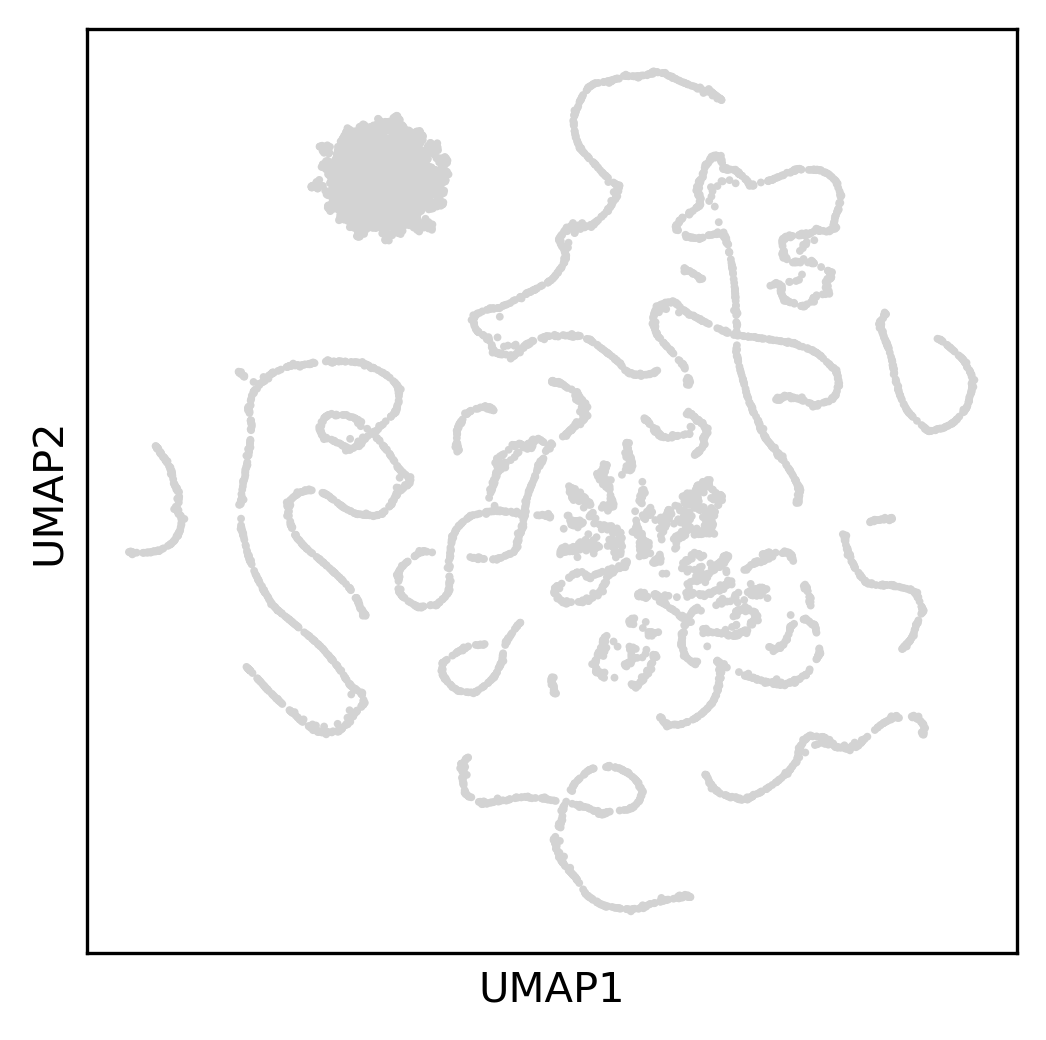

In [53]:
sc.pl.umap(data)

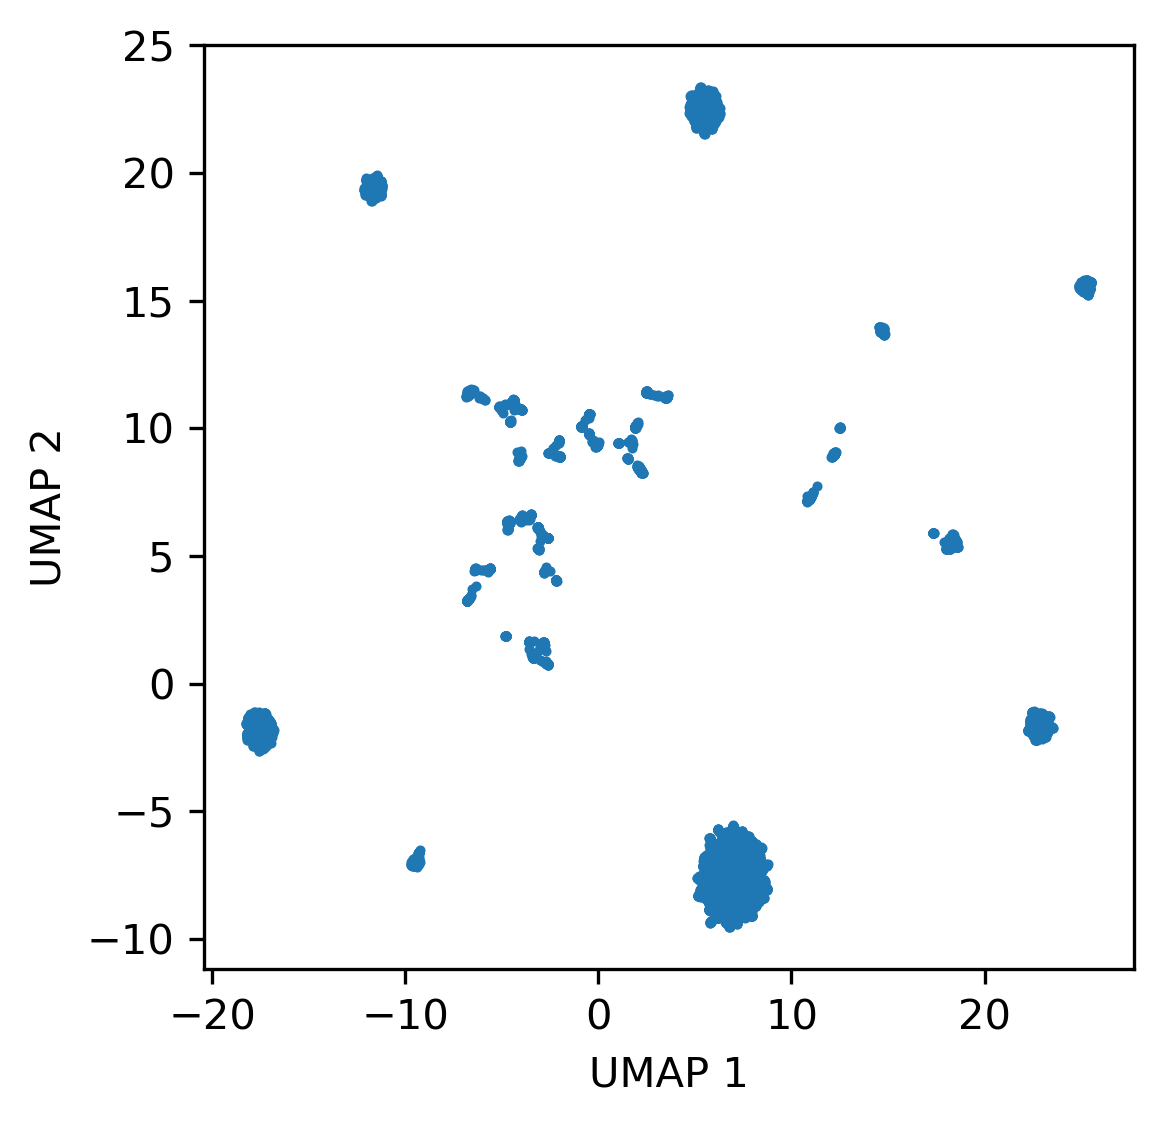

In [43]:
reducer = umap.UMAP()  
embedding = reducer.fit_transform(pdf) 

plt.scatter(
    embedding[:, 0],  # First UMAP component
    embedding[:, 1],  # Second UMAP component
    # c=df_clustered['cluster'],  # Color by cluster assignment
    # cmap='viridis',  # Choose a colormap (optional)
    s=2  # Size of the points (optional)
)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
# plt.colorbar(label='Cluster')  # Add a colorbar to indicate cluster labels
plt.show()

In [45]:
def cluster_cells(df, linkage='ward', distance_threshold=None, n_clusters=None):
    """
    Clusters single cells based on gene expression (boolean columns) in a DataFrame.

    Args:
        df: A pandas DataFrame with boolean columns representing gene presence/absence.
        linkage: The linkage criterion to use for hierarchical clustering 
                 (e.g., 'ward', 'average', 'complete'). Default is 'ward'.
        distance_threshold: The linkage distance threshold above which clusters 
                            will not be merged. If specified, n_clusters must be None.
        n_clusters: The number of clusters to form. If specified, distance_threshold 
                    must be None.

    Returns:
        A pandas DataFrame with an added 'cluster' column indicating cluster assignments.
    """
    
    # Input validation (optional, but good practice)
    if distance_threshold is not None and n_clusters is not None:
        raise ValueError("Only one of distance_threshold or n_clusters can be specified.")

    # Create the clustering model
    model = AgglomerativeClustering(
        linkage=linkage, 
        distance_threshold=distance_threshold, 
        n_clusters=n_clusters
    )

    # Fit the model to the data (transposed to cluster rows/cells)
    cluster_labels = model.fit_predict(df)

    # Add cluster labels back to the original DataFrame
    df_clustered = df.copy()
    df_clustered['cluster'] = cluster_labels
    
    return df_clustered

test = cluster_cells(pdf, n_clusters=8)
test['cluster'] = test['cluster'].astype('str')
test['cluster'].value_counts()

cluster
7    2953
0    1203
2    1166
4    1036
5     724
6     557
1     471
3     464
Name: count, dtype: int64

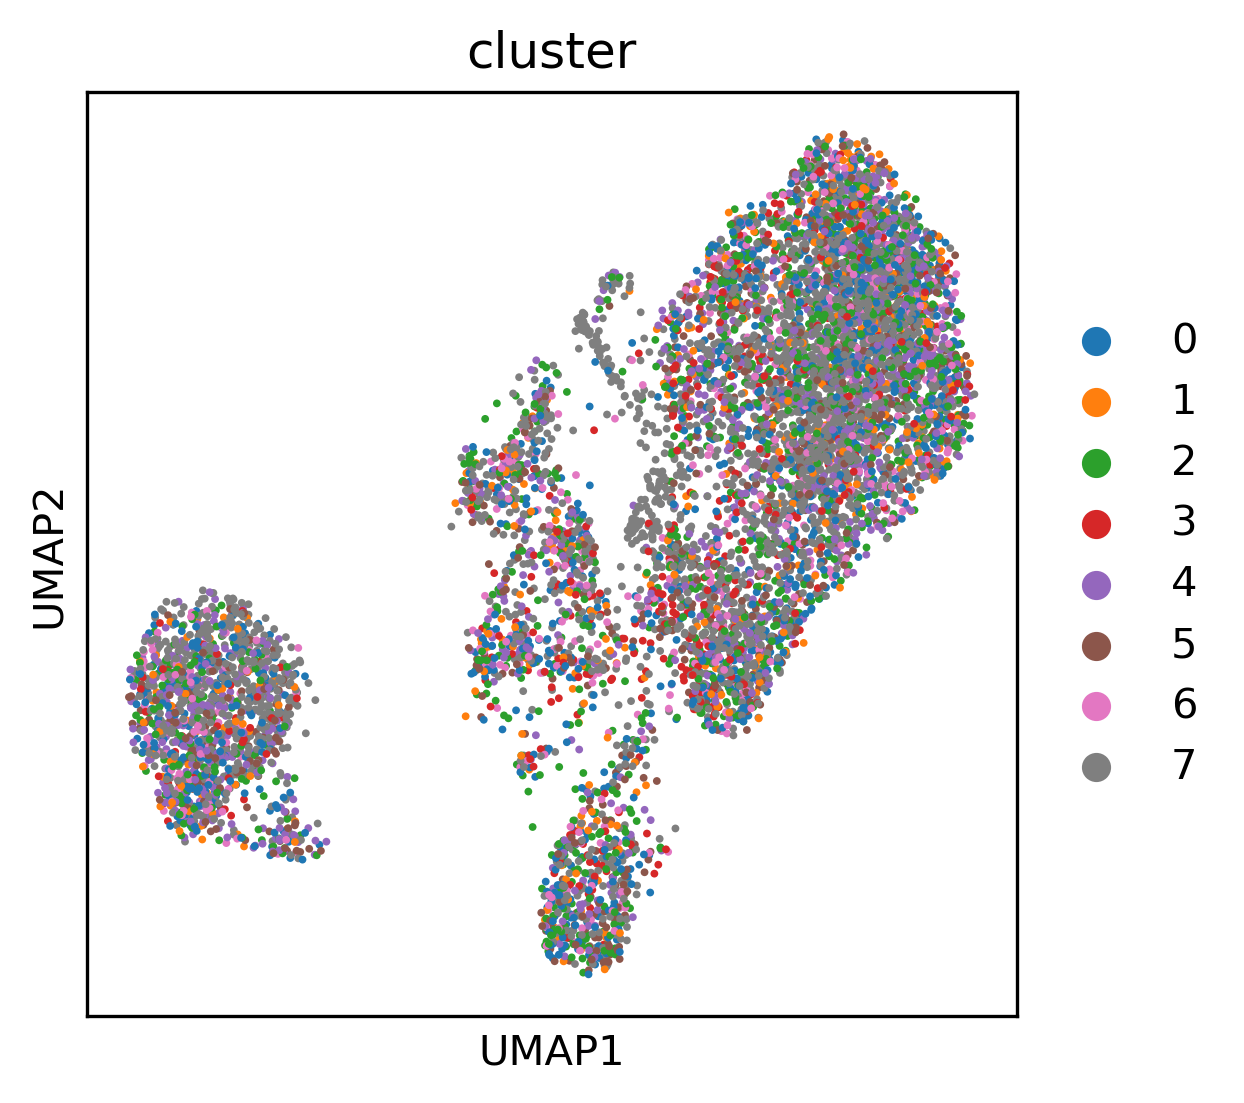

In [46]:
adata.obs['cluster'] = test['cluster']


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4
sc.pl.umap(adata,
          color='cluster')